In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import os

# 1 Explore and clean the data

_Load the data. Remove all the missing observations of V23. Now make a table (or a plot) of different answers. What is the mean satisfaction level on this planet? How large a proportion of people are at 6 or more satisfied?_

In [39]:
#Reading the data
wvs = pd.read_csv('wvs.csv.bz2', sep='\t')
#Validating the data
wvs.head()

,V2,V4,V5,V6,V7,V8,V9,V10,V11,V12,...,MN_228S8,MN_229A,MN_230A,MN_233A,MN_237B1,MN_249A1,MN_249A3,I_RELIGBEL,I_NORM1,I_VOICE1
0,12,1,1,1,-2,1,1,2,1,1,...,3,-3,-3,-3,-3,1,1,0.0,1.0,0.00
1,12,1,2,3,4,2,2,2,2,2,...,3,-3,-3,-3,-3,2,-1,0.0,1.0,0.66
2,12,1,3,2,4,2,1,2,2,2,...,4,1,1,2,-3,1,1,0.0,1.0,0.33
3,12,1,1,3,4,3,1,2,1,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.00
4,12,1,1,1,2,1,1,1,3,2,...,2,2,1,2,-3,1,2,0.0,1.0,0.66


(89771, 328)
(90350, 328)
Mean satisfaction level 6.8290316471911865


C:\Users\SP\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


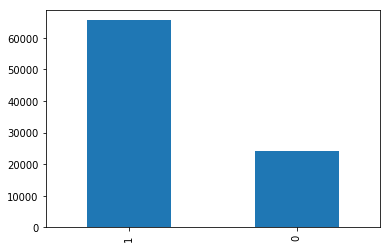

In [40]:
#Only selecting the positive outcomes on V23
valid_wvs = wvs[wvs['V23']>0]

#Validating the data
print(valid_wvs.shape)

#Checking the difference
print(wvs.shape)

#Checking the propotion of people 6 or more satisfied
valid_wvs['Above6'] = np.where(valid_wvs['V23']>=6, 1, 0)


#Creating this histogram
valid_wvs['Above6'].value_counts().plot(kind='bar')

#Mean satisfaction level
print("Mean satisfaction level", valid_wvs['V23'].mean())

__The mean satisfaction level on this planet for this dataset is 6.89__

__The number of people having above 6 satisfaction level is 3 times more than people having above 6 satisfaction level.__

# 2. Create the Design Matrix

_1. Create your outcome variable y out of life satisfaction V23_

In [41]:
#outcome variable
y = valid_wvs['V23']

_2. Create a design matrix that contains at least 100 variables from the WVS data._

In [42]:
#Creating X
X = valid_wvs.iloc[:, 0:111]

#Removing all these roles because they have a lot of values less than 0
X = X.drop('V44_ES', axis=1)
X = X.drop('V56_NZ', axis=1)
X = X.drop('V90', axis=1)
X = X.drop('V91', axis=1)
X = X.drop('V92', axis=1)
X = X.drop('V74B', axis=1)
X = X.drop('V93', axis=1)
X = X.drop('V94', axis=1)
X = X.drop('V95', axis=1)
X = X.drop('V96', axis=1)

#Validating the data
print(X.shape)

(89771, 101)


In [43]:
#Removing missing and ensuring valid data
for i, column in enumerate(list(X.columns)):
    X.drop(X[X[column]<0].index, inplace=True)

#Creating dummy columns
X_final = pd.get_dummies(X, columns = ['V2', 'V80', 'V57', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V81', 'V82',
                                      'V83', 'V12', 'V13', 'V14', 'V15', 'V16','V17', 'V18', 'V19', 'V20', 'V21',
                                      'V22', 'V24', 'V25'], drop_first=True)
#Validating the data
print(X.shape)

(35063, 101)


In [44]:
#Checking the shape
print(X_final.shape)

#Validating the data
X_final.head()

(35063, 159)


,V4,V5,V6,V7,V8,V9,V10,V11,V23,V26,...,V16_2,V17_2,V18_2,V19_2,V20_2,V21_2,V22_2,V24_2,V25_1,V25_2
2230,1,2,2,3,2,2,1,4,5,0,...,0,1,0,1,1,0,1,1,0,0
2231,1,2,2,2,1,1,2,4,5,1,...,0,1,0,1,1,0,1,1,1,0
2232,1,2,2,3,2,2,2,2,5,0,...,0,1,0,1,1,0,1,1,0,0
2233,1,2,2,3,2,1,1,2,7,0,...,0,1,1,0,1,0,1,1,0,0
2234,1,2,2,2,2,2,2,4,5,0,...,0,1,0,1,1,0,1,1,0,0


__After removing the missing and creating the dummy columns, there are finally 35063 rows and 159 columns.__

# 3 Condition numbers

In [45]:
#Calculating the condition number after every row and checking if it goes above 10000
for i in range(1,len(list(X_final.columns))):
    k = np.linalg.cond(X_final.to_numpy()[:,0:i])
    if(k>10000):
        print(i)
        break
print(k)

1067.499902845009


__The condition did not go up unpredictably. The condition number for the matrix is 1067.499.__

# 4 Do Some Social Science 

_Run a linear regression models explaining satisfaction with these three variables._

In [46]:
#Making the stats model api of linear model
print("Statsmodel.Formula.Api Method")
model1 = smf.ols(formula='V23 ~ V11 + V55 + V59', data=valid_wvs).fit()

#Parameters
print(model1.params)

#RMSE of the training data
print(np.sqrt(mean_squared_error(y, model1.fittedvalues)))

Statsmodel.Formula.Api Method
Intercept    4.274996
V11         -0.418695
V55          0.210888
V59          0.331759
dtype: float64
1.9112975277027897


__RMSE as 1.9 will serve as the benchmark for the rest of the results.__

# 5 Back to ML: Model

In [47]:
#The condition number of the model
np.linalg.cond(X_final.to_numpy())

1071.4631581702029

In [48]:
#Creating the dataframe
X_final = pd.DataFrame(X_final)

In [57]:
#Making training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_final.drop('V23', axis=1), X_final.V23, test_size=0.2, random_state=324)


In [58]:
#Calculating the condition number of the training data
np.linalg.cond(X_train)

1025.0507349845302

In [50]:
#Making linear regression model
m = LinearRegression()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)

print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

RMSE training data: 1.7457448361097134
RMSE testing data: 1.731744576955622


In [51]:
#Making a ridge model
m = Ridge()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)

print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

RMSE training data: 1.7457452030519622
RMSE testing data: 1.7317418656722223


In [52]:
#Making a lasso model
m = Lasso()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)

print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

RMSE training data: 1.990114974220637
RMSE testing data: 1.9793159557535667



            Training RMSE    Testing RMSE
    Linear        1.74             1.73

    Ridge         1.74             1.73

    Lasso         1.99             1.97

    OLS           1.9

__From the above results, we can see that there is NO significant difference between the training and testing RMSE in Linear and Ridge models. Lasso Model and OLS have slightly higher RMSE but the difference is not significant enough to conclude anything.__

# 6 Let's Overfit!

In [53]:
#Making a subset of the data
subset1 = X_final.sample(n=1000)
print(subset1.shape)
print("Condition number: ", np.linalg.cond(subset1.to_numpy()))

(1000, 159)
Condition number:  7.757716390572246e+18


__The condition number has slightly increased from the original data but the increase is not significant enough for a conclusion.__

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(subset1.drop('V23', axis=1), subset1.V23, test_size=0.2, random_state=324)

print("Linear model: ")
m = LinearRegression()
mod = m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

print("\n Ridge: ")

m = Ridge()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

print("\n Lasso: ")

m = Lasso()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

Linear model: 
RMSE training data: 1.6262874924064126
RMSE testing data: 2.0517457474157452

 Ridge: 
RMSE training data: 1.6274090856018006
RMSE testing data: 2.0381983249464257

 Lasso: 
RMSE training data: 2.061911428945449
RMSE testing data: 2.159199942548107


__From the above RMSE results, we can see that there is no significant difference in the models even after overfitting.__


In [55]:
#Testing with another subset
subset2 = X_final.sample(2000)
print(subset2.shape)
print("Condition number: ", np.linalg.cond(subset2.to_numpy()))

(2000, 159)
Condition number:  1171.0414463449472


__The condition number has slightly increased from the original data and is comparable to the 1000 sample data but the increase is not significant enough for a conclusion.__

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(subset2.drop('V23', axis=1), subset2.V23, test_size=0.2, random_state=324)

print("Linear model: ")
m = LinearRegression()
mod = m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

print("\n Ridge: ")

m = Ridge()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

print("\n Lasso: ")

m = Lasso()
m.fit(X_train, y_train)
pred = m.predict(X_valid)
pred2 = m.predict(X_train)
print('RMSE training data:', np.sqrt(mean_squared_error(y_train, pred2 )))
print('RMSE testing data:', np.sqrt(mean_squared_error(y_valid, pred)))

Linear model: 
RMSE training data: 1.646367267355582
RMSE testing data: 1.820967166716831

 Ridge: 
RMSE training data: 1.6465838337325616
RMSE testing data: 1.819327220483044

 Lasso: 
RMSE training data: 1.9680123401558813
RMSE testing data: 2.0326111967039457


__From the above RMSE results, we can see that there is no significant difference in the models even after overfitting with 2000 rows of sample data.__